In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *

# IF RUNNING ON COLAB
if is_colab():
  !pip install -U -q PyDrive

  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  !pip install -U -q keras_self_attention
  !pip install -U -q pypianoroll
  !pip install -U -q keras_tqdm

  from google.colab import drive
  drive.mount('/gdrive')

In [28]:
import keras
import numpy as np
from utils import *
import os
from keras_self_attention import *
import matplotlib.pyplot as plt
import pypianoroll
from utils import *
from glob import glob
from generator import *
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [5]:
if os.path.exists("/gdrive") and not os.path.exists("/content/folkdataset_trim4"):
    import tarfile
    fname = "/gdrive/My Drive/THESIS/folkdataset_trim4.tar"
    if (fname.endswith("tar.gz")):
        tar = tarfile.open(fname, "r:gz")
        tar.extractall()
        tar.close()
    elif (fname.endswith("tar")):
        tar = tarfile.open(fname, "r:")
        tar.extractall()
        tar.close()

In [5]:
%pwd

'D:\\data\\thesis_model2'

In [16]:
from config import FOLK_DATASET_TRIM_4

# Load model

In [6]:
MODEL_ID = 'model_trim_4bars_2lstm_att'
if os.path.exists("/gdrive/"):
    MODEL_ID = os.path.join("/gdrive", "My Drive", "THESIS", MODEL_ID)  

In [7]:
json_model = open(os.path.join(MODEL_ID,"model.json"),"r").read()

In [8]:
model = keras.models.model_from_json(json_model, custom_objects=SeqWeightedAttention.get_custom_objects())

model.load_weights(os.path.join(MODEL_ID, "model.h5"))

# Sampling

In [9]:
from build_dataset import min_max_from_folder, reconstruct_full_sequence

In [19]:
VOCAB_SIZE = FOLK_DATASET_TRIM_4['VOCAB_SIZE']
BAR_LEN = FOLK_DATASET_TRIM_4['BAR_LEN']
NR_BARS = FOLK_DATASET_TRIM_4['NR_BARS']
SEQ_LEN = BAR_LEN*NR_BARS-1

In [18]:
mi, ma = FOLK_DATASET_TRIM_4['mi'], FOLK_DATASET_TRIM_4['ma']
print(mi, ma)

48 95


In [22]:
midi_seed_sequence_path = "D:/data/helio.mid"
seed_sequence = load_pianoroll_fromfile(midi_seed_sequence_path)[:SEQ_LEN, mi:ma]
seed_sequence.shape

(383, 47)

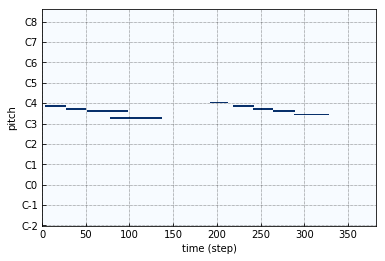

In [23]:
pm = parse_generated_piano_roll_to_midi(reconstruct_full_sequence(seed_sequence, mi, ma))
pm.plot()
plt.show()

(768, 47)


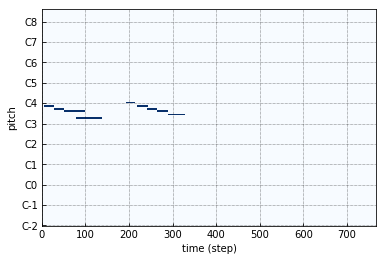

In [24]:
generated = np.zeros((8*BAR_LEN, seed_sequence.shape[1]))
print(generated.shape)
generated[:seed_sequence.shape[0]] = seed_sequence

pm = parse_generated_piano_roll_to_midi(reconstruct_full_sequence(generated, mi, ma))
pm.plot()
plt.show()


In [25]:
seed_seq_len = BAR_LEN*NR_BARS-1

In [26]:
seed_seq_len, len(generated)

(383, 768)

100%|████████████████████████████████████████████████████████████████████████████| 385/385 [00:26<00:00, 14.39it/s]


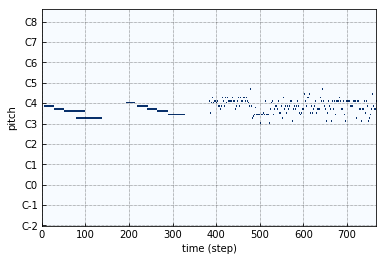

In [31]:
prev_seq = None

temps = []

for timestep in tqdm(list(range(seed_seq_len, len(generated)))):
#     print(timestep)
    start_index = timestep - (seed_seq_len)
#     print(start_index, timestep)
    sequence_for_prediction = generated[start_index:timestep]
    temperature = 1.0
    temps.append(temperature)
    next_step = sample(model, sequence_for_prediction, temperature)
    prev_seq = sequence_for_prediction
    generated[timestep] = next_step


generated[generated == 1] = 127


pm = parse_generated_piano_roll_to_midi(reconstruct_full_sequence(generated, mi, ma))
pm.plot()
plt.show()

pm = pypianoroll.Multitrack(tracks=[pm])

In [ ]:
filename = "temp-%s.mid" %(temperature)
if is_colab():
    if not os.path.exists('/gdrive/My Drive/THESIS/%s/generated/' %MODEL_ID):
        os.mkdir('/gdrive/My Drive/THESIS/%s/generated/' %MODEL_ID)
    generated_file = os.path.join("/gdrive/My Drive/THESIS/%s/generated/%s" %(MODEL_ID,filename))
else:
    if not os.path.exists('%s/generated/' %MODEL_ID):
        os.mkdir('%s/generated/' %MODEL_ID)
    generated_file = os.path.join("%s/generated/%s" %(MODEL_ID,filename))
print('writing %s' %generated_file)
pm.write(generated_file)